# Tessellate RL Training
## Minimal, Interpretable Reinforcement Learning

This notebook trains a simple 2-layer neural network to evaluate Tessellate board positions.
- **No hand-crafted features** - just raw board state
- **Minimal architecture** - 101 inputs → 128 hidden → 1 output
- **Focus on interpretability** - see what patterns emerge

In [1]:
import json
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time
from typing import List, Dict, Tuple

# Game constants
BOARD_SIZE = 10
EMPTY = 0
RED = 1
BLUE = 2
BLOCKED = 3

print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.8.0


## 1. Define the Model

Simplest possible value network:
- Input: Flattened board (100) + current player (1) = 101 features
- Hidden: 128 neurons with ReLU
- Output: Single value (-1 to 1) indicating position quality

In [2]:
class TessellateValueNet(nn.Module):
    def __init__(self, input_size=101, hidden_size=128):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.tanh(self.fc2(x))  # Output between -1 and 1
        return x

model = TessellateValueNet()
print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Model architecture: {model}")

Model parameters: 13185
Model architecture: TessellateValueNet(
  (fc1): Linear(in_features=101, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (tanh): Tanh()
)


## 2. Load Game Data

In [13]:
def load_games(filepath: str, max_games: int = None) -> List[Dict]:
    """Load games from JSON file"""
    print(f"Loading games from {filepath}...")
    with open(filepath, 'r') as f:
        games = json.load(f)
    if max_games:
        games = games[:max_games]
    print(f"Loaded {len(games)} games")
    
    # Statistics
    red_wins = sum(1 for g in games if g.get('winner') == RED)
    blue_wins = sum(1 for g in games if g.get('winner') == BLUE)
    ties = len(games) - red_wins - blue_wins
    
    print(f"  Red wins: {red_wins} ({100*red_wins/len(games):.1f}%)")
    print(f"  Blue wins: {blue_wins} ({100*blue_wins/len(games):.1f}%)")
    print(f"  Ties: {ties} ({100*ties/len(games):.1f}%)")
    
    return games

# Load games - start with 1000 for testing
# games = load_games("game_data/random_games_1000.json")

# For full training with 1M games:
games = load_games("game_data/all_games_20250815_141840_1000000.json", max_games=100000)

Loading games from game_data/all_games_20250815_141840_1000000.json...
Loaded 100000 games
  Red wins: 49415 (49.4%)
  Blue wins: 49371 (49.4%)
  Ties: 1214 (1.2%)


## 3. Prepare Training Data

Convert games to (state, value) pairs for supervised learning

In [14]:
def board_to_tensor(board_state: List[List[int]], current_player: int) -> torch.Tensor:
    """Convert board state to tensor (no feature engineering!)"""
    flat_board = np.array(board_state).flatten()
    state = np.append(flat_board, current_player)
    return torch.FloatTensor(state)

def reconstruct_board_states(game: Dict) -> List[Tuple[np.ndarray, int, float]]:
    """Reconstruct board states from a game's moves"""
    states = []
    board = [[EMPTY for _ in range(BOARD_SIZE)] for _ in range(BOARD_SIZE)]
    
    # Determine game outcome
    winner = game.get('winner')
    if winner == RED:
        final_value = 1.0
    elif winner == BLUE:
        final_value = -1.0
    else:
        final_value = 0.0
    
    # Process each move
    for i, move in enumerate(game['moves']):
        player = move['player']
        r, c = move['position']
        
        # Store state BEFORE move
        board_copy = [row[:] for row in board]
        
        # Simple value: interpolate from 0 to final
        progress = i / len(game['moves'])
        value = final_value * progress
        
        states.append((board_copy, player, value))
        
        # Apply move
        board[r][c] = player
        
        # Block adjacent
        c_adj = c + (1 if c % 2 == 0 else -1)
        if 0 <= c_adj < BOARD_SIZE and board[r][c_adj] == EMPTY:
            board[r][c_adj] = BLOCKED
            
        r_adj = r + (1 if r % 2 == 0 else -1)
        if 0 <= r_adj < BOARD_SIZE and board[r_adj][c] == EMPTY:
            board[r_adj][c] = BLOCKED
    
    return states

In [15]:
def create_training_data(games: List[Dict], samples_per_game: int = 5):
    """Create training data from games"""
    X = []
    y = []
    
    for game_idx, game in enumerate(games):
        if game_idx % 100 == 0:
            print(f"Processing game {game_idx}/{len(games)}")
        
        states = reconstruct_board_states(game)
        
        # Sample positions
        if len(states) > samples_per_game:
            indices = np.random.choice(len(states), samples_per_game, replace=False)
            sampled_states = [states[i] for i in indices]
        else:
            sampled_states = states
        
        for board, player, value in sampled_states:
            X.append(board_to_tensor(board, player))
            y.append(value)
    
    return torch.stack(X), torch.FloatTensor(y)

# Create training data
X, y = create_training_data(games, samples_per_game=5)
print(f"\nTraining samples: {len(X)}")
print(f"Value distribution: min={y.min():.2f}, mean={y.mean():.2f}, max={y.max():.2f}")

Processing game 0/100000
Processing game 100/100000
Processing game 200/100000
Processing game 300/100000
Processing game 400/100000
Processing game 500/100000
Processing game 600/100000
Processing game 700/100000
Processing game 800/100000
Processing game 900/100000
Processing game 1000/100000
Processing game 1100/100000
Processing game 1200/100000
Processing game 1300/100000
Processing game 1400/100000
Processing game 1500/100000
Processing game 1600/100000
Processing game 1700/100000
Processing game 1800/100000
Processing game 1900/100000
Processing game 2000/100000
Processing game 2100/100000
Processing game 2200/100000
Processing game 2300/100000
Processing game 2400/100000
Processing game 2500/100000
Processing game 2600/100000
Processing game 2700/100000
Processing game 2800/100000
Processing game 2900/100000
Processing game 3000/100000
Processing game 3100/100000
Processing game 3200/100000
Processing game 3300/100000
Processing game 3400/100000
Processing game 3500/100000
Proc

## 4. Train the Model

In [16]:
# Training setup
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Create data loader
dataset = torch.utils.data.TensorDataset(X, y)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64)

print(f"Training samples: {train_size}")
print(f"Validation samples: {val_size}")

Training samples: 400000
Validation samples: 100000


In [17]:
# Training loop
train_losses = []
val_losses = []

epochs = 10
for epoch in range(epochs):
    # Training
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X).squeeze()
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            predictions = model(batch_X).squeeze()
            loss = criterion(predictions, batch_y)
            val_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

Epoch 1/10 - Train Loss: 0.3191, Val Loss: 0.3204
Epoch 2/10 - Train Loss: 0.3151, Val Loss: 0.3139
Epoch 3/10 - Train Loss: 0.3129, Val Loss: 0.3116
Epoch 4/10 - Train Loss: 0.3116, Val Loss: 0.3152
Epoch 5/10 - Train Loss: 0.3105, Val Loss: 0.3111
Epoch 6/10 - Train Loss: 0.3095, Val Loss: 0.3122
Epoch 7/10 - Train Loss: 0.3078, Val Loss: 0.3089
Epoch 8/10 - Train Loss: 0.3067, Val Loss: 0.3066
Epoch 9/10 - Train Loss: 0.3054, Val Loss: 0.3073
Epoch 10/10 - Train Loss: 0.3039, Val Loss: 0.3079


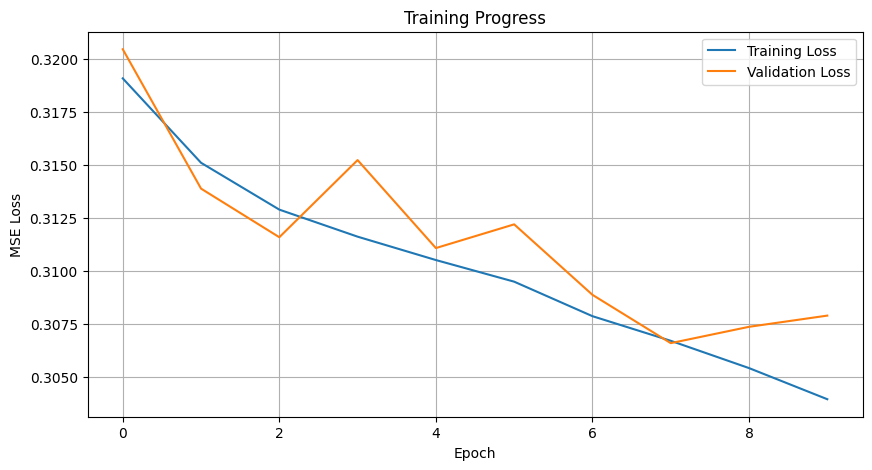

In [18]:
# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Progress')
plt.legend()
plt.grid(True)
plt.show()

## 5. Analyze What the Model Learned

In [19]:
# Test on a few games
model.eval()
test_games = games[:3]

for i, game in enumerate(test_games):
    states = reconstruct_board_states(game)
    
    print(f"\nGame {i+1} - Winner: {game.get('winner', 'Tie')}")
    print(f"Final scores - Red: {game['final_scores']['red']}, Blue: {game['final_scores']['blue']}")
    
    # Check predictions at key points
    checkpoints = [0, len(states)//4, len(states)//2, 3*len(states)//4, len(states)-1]
    
    for pos in checkpoints:
        if pos < len(states):
            board, player, true_value = states[pos]
            x = board_to_tensor(board, player).unsqueeze(0)
            
            with torch.no_grad():
                pred_value = model(x).item()
            
            move_pct = (pos / len(states)) * 100
            print(f"  Move {pos}/{len(states)} ({move_pct:.0f}%): "
                  f"Predicted: {pred_value:+.3f}, True: {true_value:+.3f}")


Game 1 - Winner: 1
Final scores - Red: 352, Blue: 240
  Move 0/50 (0%): Predicted: -0.010, True: +0.000
  Move 12/50 (24%): Predicted: +0.037, True: +0.240
  Move 25/50 (50%): Predicted: -0.082, True: +0.500
  Move 37/50 (74%): Predicted: +0.082, True: +0.740
  Move 49/50 (98%): Predicted: +0.002, True: +0.980

Game 2 - Winner: 1
Final scores - Red: 1080, Blue: 288
  Move 0/50 (0%): Predicted: -0.010, True: +0.000
  Move 12/50 (24%): Predicted: -0.061, True: +0.240
  Move 25/50 (50%): Predicted: +0.008, True: +0.500
  Move 37/50 (74%): Predicted: +0.040, True: +0.740
  Move 49/50 (98%): Predicted: +0.192, True: +0.980

Game 3 - Winner: 1
Final scores - Red: 1188, Blue: 672
  Move 0/50 (0%): Predicted: -0.010, True: +0.000
  Move 12/50 (24%): Predicted: -0.026, True: +0.240
  Move 25/50 (50%): Predicted: +0.045, True: +0.500
  Move 37/50 (74%): Predicted: -0.146, True: +0.740
  Move 49/50 (98%): Predicted: -0.018, True: +0.980


## 6. Visualize Position Values

Create a heatmap showing which starting positions the model thinks are good

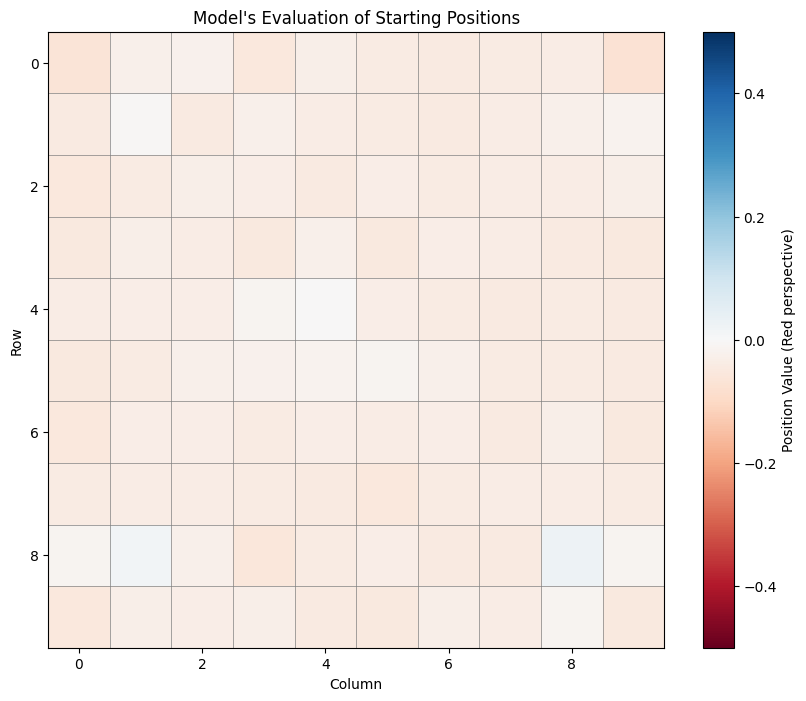

Red areas = model thinks good for RED
Blue areas = model thinks good for BLUE

Max value: 0.024 at position (np.int64(8), np.int64(8))
Min value: -0.071 at position (np.int64(0), np.int64(9))


In [20]:
# Evaluate empty board positions
board = [[EMPTY for _ in range(BOARD_SIZE)] for _ in range(BOARD_SIZE)]
values = np.zeros((BOARD_SIZE, BOARD_SIZE))

for r in range(BOARD_SIZE):
    for c in range(BOARD_SIZE):
        # Temporarily place RED piece
        board[r][c] = RED
        x = board_to_tensor(board, BLUE).unsqueeze(0)
        
        with torch.no_grad():
            value = model(x).item()
        values[r, c] = value
        
        # Remove piece
        board[r][c] = EMPTY

# Plot heatmap
plt.figure(figsize=(10, 8))
plt.imshow(values, cmap='RdBu', vmin=-0.5, vmax=0.5)
plt.colorbar(label='Position Value (Red perspective)')
plt.title('Model\'s Evaluation of Starting Positions')
plt.xlabel('Column')
plt.ylabel('Row')

# Add grid
for i in range(BOARD_SIZE + 1):
    plt.axhline(i - 0.5, color='gray', linewidth=0.5)
    plt.axvline(i - 0.5, color='gray', linewidth=0.5)

plt.show()

print("Red areas = model thinks good for RED")
print("Blue areas = model thinks good for BLUE")
print(f"\nMax value: {values.max():.3f} at position {np.unravel_index(values.argmax(), values.shape)}")
print(f"Min value: {values.min():.3f} at position {np.unravel_index(values.argmin(), values.shape)}")